In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
data = pd.read_csv('SampleFile2.csv')

# Convert the date column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Filter the data to include only the previous two years before 04-29-2024
cutoff_date = pd.Timestamp('2024-04-29')
start_date = cutoff_date - pd.DateOffset(years=2)
data = data[(data['Date'] >= start_date) & (data['Date'] < cutoff_date)]

# Display basic information about the filtered dataset
print(data.info())
print(data.describe())


C:\Users\AbdulRafay\AppData\Local\Temp\ipykernel_29300\2506689647.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('SampleFile2.csv')


<class 'pandas.core.frame.DataFrame'>
Index: 286934 entries, 52935 to 376060
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   N+C                     286934 non-null  object        
 1   Shop                    286934 non-null  object        
 2   Region                  286934 non-null  object        
 3   Channel                 286934 non-null  object        
 4   LI                      286934 non-null  object        
 5   Gender                  286934 non-null  object        
 6   Category                286934 non-null  object        
 7   Class                   286934 non-null  object        
 8   Sub-Class               286934 non-null  object        
 9   Season                  286934 non-null  object        
 10  Product Name            286934 non-null  object        
 11  Color                   286934 non-null  object        
 12  Size                    286934 

In [4]:
# Sort the data by date
data = data.sort_values('Date')

# Extract time-based features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['WeekOfYear'] = data['Date'].dt.isocalendar().week

# Label encode categorical variables
label_encoders = {}
for column in ['Shop', 'Product Name']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Define features and target

target = 'Sales Amount'
features = ['Shop', 'Product Name', 'Year', 'Month', 'Day', 'DayOfWeek', 'WeekOfYear']

In [5]:
# Split the data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = train_test_split(data, train_size=train_size, random_state=42)


In [6]:
# Identify high sales months in the training set
train_data['Date'] = pd.to_datetime(train_data['Date'])
monthly_sales = train_data.groupby(['Product Name', 'Shop', train_data['Date'].dt.month])['Sales Amount'].sum().reset_index()
high_sales_months = monthly_sales.groupby(['Product Name', 'Shop'])['Sales Amount'].transform(lambda x: x > x.mean())
monthly_sales['high_sales'] = high_sales_months.astype(int)

# Merge the high_sales feature back to the train_data
train_data = train_data.merge(
    monthly_sales[['Product Name', 'Shop', 'Date', 'high_sales']], 
    left_on=['Product Name', 'Shop', 'Month'], 
    right_on=['Product Name', 'Shop', 'Date'],
    how='left'
)



In [7]:
train_data = train_data.drop(columns=['Date_y']).rename(columns={'Date_x': 'Date'})
train_data['high_sales'] = train_data['high_sales'].fillna(0).astype(int)


In [8]:
# Set high_sales feature in the test set based on the training set high sales months
test_data['high_sales'] = 0
for _, row in monthly_sales[high_sales_months].iterrows():
    test_data.loc[(test_data['Product Name'] == row['Product Name']) & 
                  (test_data['Shop'] == row['Shop']) & 
                  (test_data['Month'] == row['Date']), 'high_sales'] = 1

In [9]:
# Handle missing values by filling forward and backward
train_data = train_data.bfill().ffill()
test_data = test_data.bfill().ffill()

# Ensure there's still data available
if train_data.empty or test_data.empty:
    raise ValueError("No data available after handling missing values. Check your dataset.")

In [10]:
# Define features and target for training and testing
X_train = train_data[features + ['high_sales']]
y_train = train_data[target]
X_test = test_data[features + ['high_sales']]
y_test = test_data[target]

In [11]:
# Ensure there is enough data to train the model
if len(X_train) == 0 or len(X_test) == 0:
    raise ValueError("Insufficient data to train the model. Adjust the train/test split or check your dataset.")


In [12]:
# Train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
# Make predictions
y_pred = model.predict(X_test)

In [14]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 121.88265230022003


In [15]:
# Feature importance
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': features + ['high_sales'], 'Importance': importances})
print(feature_importances.sort_values(by='Importance', ascending=False))

        Feature  Importance
1  Product Name    0.873943
6    WeekOfYear    0.048228
2          Year    0.025514
0          Shop    0.016225
4           Day    0.015859
5     DayOfWeek    0.009042
3         Month    0.006684
7    high_sales    0.004505


In [16]:
# Add predictions to the test set for analysis
test_data['Predicted Sales Amount'] = y_pred

In [17]:
# Group by Product Name (N+C) and Shop to get actual and predicted sales
actual_sales_product = test_data.groupby('Product Name')['Sales Amount'].sum().reset_index()
predicted_sales_product = test_data.groupby('Product Name')['Predicted Sales Amount'].sum().reset_index()

actual_sales_shop = test_data.groupby('Shop')['Sales Amount'].sum().reset_index()
predicted_sales_shop = test_data.groupby('Shop')['Predicted Sales Amount'].sum().reset_index()


In [18]:
# Calculate errors
product_errors = actual_sales_product.merge(predicted_sales_product, on='Product Name')
product_errors['Error'] = np.abs(product_errors['Sales Amount'] - product_errors['Predicted Sales Amount'])

shop_errors = actual_sales_shop.merge(predicted_sales_shop, on='Shop')
shop_errors['Error'] = np.abs(shop_errors['Sales Amount'] - shop_errors['Predicted Sales Amount'])


In [19]:
# Identify combinations with lowest and highest errors
lowest_error_product = product_errors.sort_values(by='Error').head(5)
highest_error_product = product_errors.sort_values(by='Error').tail(5)

lowest_error_shop = shop_errors.sort_values(by='Error').head(5)
highest_error_shop = shop_errors.sort_values(by='Error').tail(5)

print("Lowest Error Products:\n", lowest_error_product)
print("Highest Error Products:\n", highest_error_product)
print("Lowest Error Shops:\n", lowest_error_shop)
print("Highest Error Shops:\n", highest_error_shop)


Lowest Error Products:
      Product Name  Sales Amount  Predicted Sales Amount  Error
253           269        1000.0                  1000.0    0.0
685           711      189000.0                189000.0    0.0
611           637        2600.0                  2600.0    0.0
94            100        9237.3                  9237.3    0.0
243           258         500.0                   500.0    0.0
Highest Error Products:
      Product Name  Sales Amount  Predicted Sales Amount         Error
906           956     160071.47           198144.705341  38073.235341
534           559     496407.87           457327.622867  39080.247133
915           965     425170.77           381971.993961  43198.776039
920           970     347292.75           275364.698172  71928.051828
616           642     526078.70           617520.430866  91441.730866
Lowest Error Shops:
     Shop  Sales Amount  Predicted Sales Amount       Error
37    38       6419.92             6372.378100   47.541900
18    18      

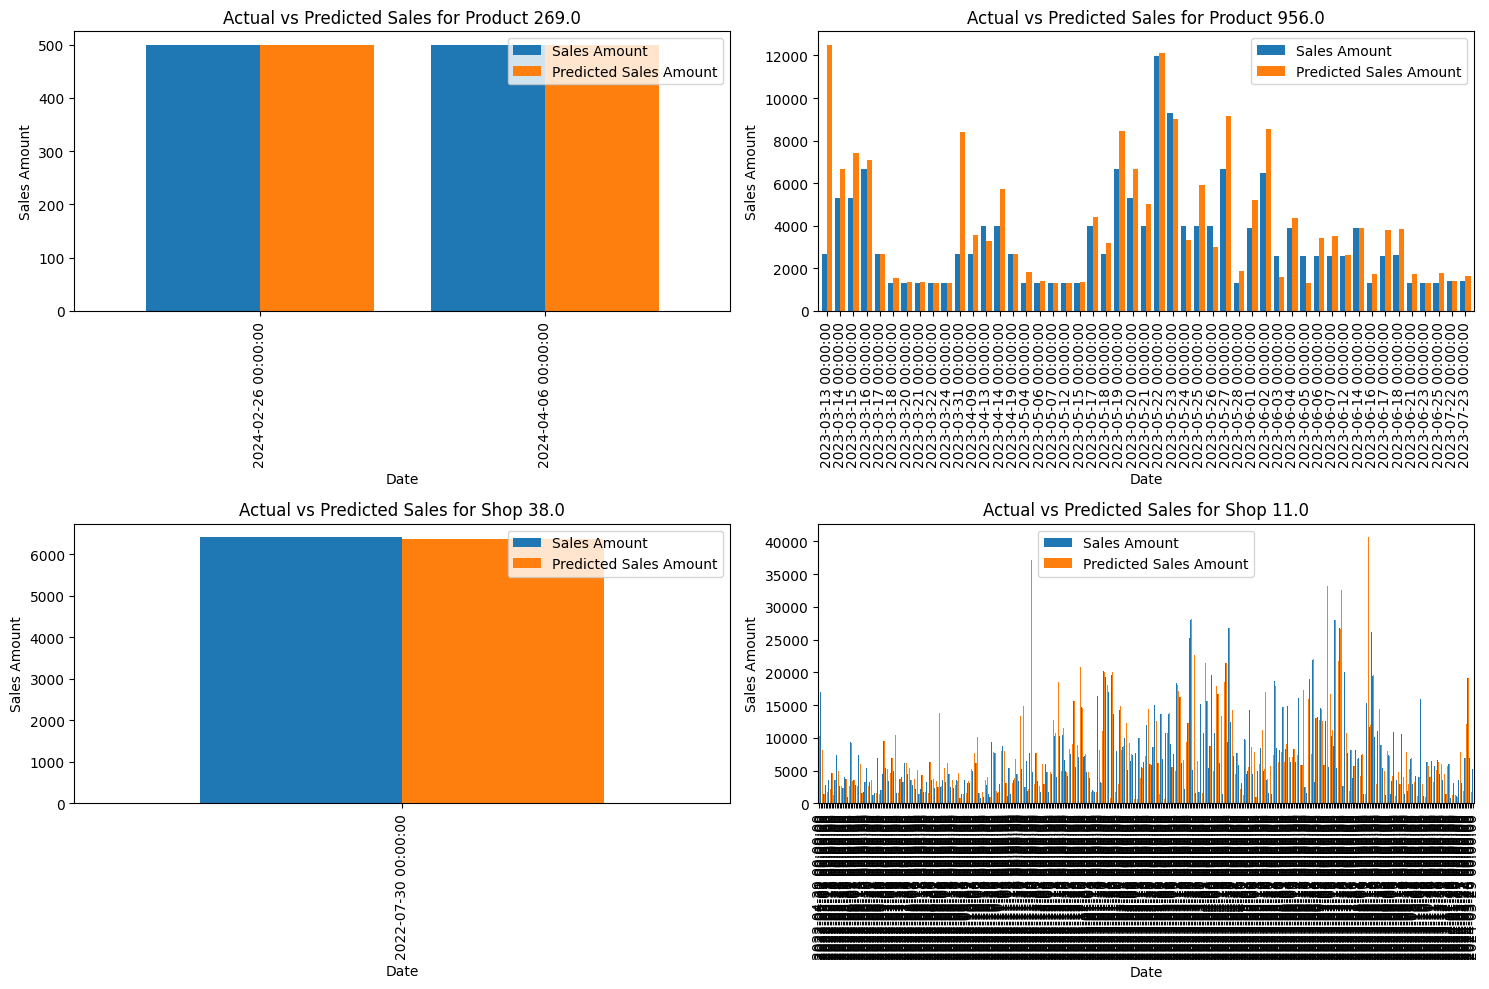

In [21]:
# Plot actual vs predicted sales for a few selected combinations using bar plots
plt.figure(figsize=(15, 10))

# Plot for Product with Lowest Error
plt.subplot(2, 2, 1)
product_name = lowest_error_product.iloc[0]['Product Name']
product_data = test_data[test_data['Product Name'] == product_name]
product_data_grouped = product_data.groupby('Date')[['Sales Amount', 'Predicted Sales Amount']].sum().reset_index()
product_data_grouped.plot(kind='bar', x='Date', ax=plt.gca(), width=0.8)
plt.title(f'Actual vs Predicted Sales for Product {product_name}')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=90)
plt.legend()

# Plot for Product with Highest Error
plt.subplot(2, 2, 2)
product_name = highest_error_product.iloc[0]['Product Name']
product_data = test_data[test_data['Product Name'] == product_name]
product_data_grouped = product_data.groupby('Date')[['Sales Amount', 'Predicted Sales Amount']].sum().reset_index()
product_data_grouped.plot(kind='bar', x='Date', ax=plt.gca(), width=0.8)
plt.title(f'Actual vs Predicted Sales for Product {product_name}')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=90)
plt.legend()

# Plot for Shop with Lowest Error
plt.subplot(2, 2, 3)
shop_name = lowest_error_shop.iloc[0]['Shop']
shop_data = test_data[test_data['Shop'] == shop_name]
shop_data_grouped = shop_data.groupby('Date')[['Sales Amount', 'Predicted Sales Amount']].sum().reset_index()
shop_data_grouped.plot(kind='bar', x='Date', ax=plt.gca(), width=0.8)
plt.title(f'Actual vs Predicted Sales for Shop {shop_name}')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=90)
plt.legend()

# Plot for Shop with Highest Error
plt.subplot(2, 2, 4)
shop_name = highest_error_shop.iloc[0]['Shop']
shop_data = test_data[test_data['Shop'] == shop_name]
shop_data_grouped = shop_data.groupby('Date')[['Sales Amount', 'Predicted Sales Amount']].sum().reset_index()
shop_data_grouped.plot(kind='bar', x='Date', ax=plt.gca(), width=0.8)
plt.title(f'Actual vs Predicted Sales for Shop {shop_name}')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()